# Monitoring vegetation for biodiversity  
### Using High Resolution Phenology and Productivity (HR-VPP) datasets and the OpenEO data cube processing API

### Purpose of this notebook
This notebook demonstrates the calculation of **time series** profiles and **statistics**
for **administrative areas in Europe** and specific **land cover or ecosystems** relevant for **biodiversity**.

The calculations are performed by using the **OpenEO API**, for one small area to limit the amount of cloud computations.

The OpenEO API provides a harmonized and easy way to perform data cube processing on Earth Observation datasets, hosted on different cloud back-ends.

Please see *[the OpenEO web site](https://openeo.org/)* and *[Getting Started with OpenEO in Python](https://docs.openeo.cloud/getting-started/python/)*  
for more info on OpenEO including tutorials, an online code editor and much more.

### Prerequisites

##### Jupyter interactive notebook service and cloud platform
This notebook was developed on the Jupyter Hub of the *[Copernicus Dataspace Ecosystem](https://dataspace.copernicus.eu/)*  
This Jupyter service offers an OpenEO kernel that comes with openEO client and all the below Python packages except geopandas.

##### Python package imports
To run the below code, the following packages need to be installed in the Python 3 environment:
* xarray
* netcdf4
* pandas
* geopandas
* numpy, pandas and matplotlib are used in the helper script
* open source openEO Python client package

To install missing packages, use a pip command like this:

In [1]:
%%capture
!pip install -U --user openeo geopandas;

In [2]:
# General-purpose Python packages
import xarray as xr
import pandas as pd
import geopandas as gpd

In [3]:
# OpenEO API client
import openeo
from openeo.processes import array_create, quantiles, mean, sd

# This code was developed with OpenEO API client version 0.28.0, but may work with other versions as well.
openeo.__version__

'0.28.0'

In [4]:
# Helper script for handling the HR-VPP colour palettes
from helper import *

##### Ancillary input files
The **NUTS area polygons** can be downloaded from *[this Eurostat web site](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts)*

**Colour palettes** can be downloaded from *[this EEA GitHub repository](https://github.com/eea/clms-hrvpp-colourmaps)*

##### Background on the Merzig-Wadern district, the selected NUTS level 3 area
Merzig-Wadern is a district in the northwest of Saarland, Germany.  
In this district, just north of the city of Beckingen, lies the *[Wolferskopf Nature Reserve](https://www.beckingen.de/tourismus-und-kultur/naturschutzgebiet-wolferskopf/)*. The nature reserve of 337 ha is home to 450 plant species, 60 species of birds and many butterflies and small animals like grasshoppers and snakes.


### Connect to openEO back-end and sign in
When establishing the connection to the back-end, you may be prompted to log in through a web site.

In [5]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=FVVC-LRWX 📋 to authenticate.

[####################################-] ✅ Authorized successfully

Authenticated using device code flow.


### Load administrative area polygon (NUTS area)

We read in the geopandas file and extract the area.
Later on we can utilize this area as a spatial filter for our cube

In [6]:
spatial_geometries = gpd.read_file('NUTS/NUTS_RG_01M_2021_3035_DEC02.shp')
spatial_geometries = spatial_geometries.to_crs(epsg=4326)
dec02_area = eval(spatial_geometries.to_json())

dec02_area['features'][0]['properties']['NUTS_NAME']

'Merzig-Wadern'

### Prepare mask from land cover

Load the available **ESA WorldCover** dataset for year 2021, 
then filter the land cover classes of interest 
and download the resulting mask.

In this demo, we'll filter the land cover class for grassland (30).

Please see the *[WorldCover web site](https://esa-worldcover.org/)* or the *[user manual](https://worldcover2020.esa.int/data/docs/WorldCover_PUM_V1.1.pdf)*  
for more information on the WorldCover dataset.

In [7]:
# load in the WorldCover data, filtering it on the desired area
worldcover = connection.load_collection("ESA_WORLDCOVER_10M_2021_V2",
                                        temporal_extent= ["2021-01-01","2021-12-31"],
                                        bands=["MAP"]).filter_spatial(dec02_area)

# Create a boolean mask for the classes of interest
classmask = ~((worldcover.band("MAP") == 30)) * 1.0

# Apply the boolean mask, so that the land cover data cube only includes class 30
masked_cube_worldcover = worldcover.mask(classmask)

# Execute the data cube processing and save the result in a netCDF (.nc) raster file
job = masked_cube_worldcover.execute_batch(outputfile = 'WORLD_COVER_DEC02_CLASS300.nc',
                                description='benchmarking-creo',
                                job_options={'driver-memory': '1g'},
                                validate = False)

0:00:00 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': send 'start'
0:00:14 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:00:20 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:00:26 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:00:34 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:00:44 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:00:57 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:01:13 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:01:32 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:01:56 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': running (progress N/A)
0:02:26 Job 'j-24050294e12c4a6d9831cc9e7ebad6a6': finished (progress N/A)


### Load HR-VPP Seasonal Trajectories PPI data cube and mask it

In [23]:
# Load HR-VPP Seasonal Trajectories PPI data for July 2021
cube_st_ppi = connection.load_collection("COPERNICUS_PLANT_PHENOLOGY_INDEX",
                                        temporal_extent = ["2021-07-01","2021-07-31"],
                                        bands=["PPI"]).filter_spatial(dec02_area)

mask_for_ppi = classmask.max_time().resample_cube_spatial(cube_st_ppi)
masked_cube_st_ppi = cube_st_ppi.mask(mask_for_ppi)

#excecute the job and 
job = masked_cube_st_ppi.execute_batch(outputfile = 'HRVPP_SEASONAL_TRAJECTORIES_JULY2021.nc',
                                       description='benchmarking-creo',
                                       job_options={'driver-memory': '1g'},
                                       sample_by_feature = True,
                                       validate = False)

0:00:00 Job 'j-2405027a81504d70bd6debbedbc6d6c9': send 'start'
0:00:14 Job 'j-2405027a81504d70bd6debbedbc6d6c9': created (progress N/A)
0:00:20 Job 'j-2405027a81504d70bd6debbedbc6d6c9': created (progress N/A)
0:00:29 Job 'j-2405027a81504d70bd6debbedbc6d6c9': created (progress N/A)
0:00:38 Job 'j-2405027a81504d70bd6debbedbc6d6c9': created (progress N/A)
0:00:48 Job 'j-2405027a81504d70bd6debbedbc6d6c9': created (progress N/A)
0:01:01 Job 'j-2405027a81504d70bd6debbedbc6d6c9': running (progress N/A)
0:01:17 Job 'j-2405027a81504d70bd6debbedbc6d6c9': running (progress N/A)
0:01:36 Job 'j-2405027a81504d70bd6debbedbc6d6c9': running (progress N/A)
0:02:01 Job 'j-2405027a81504d70bd6debbedbc6d6c9': running (progress N/A)
0:02:31 Job 'j-2405027a81504d70bd6debbedbc6d6c9': running (progress N/A)
0:03:09 Job 'j-2405027a81504d70bd6debbedbc6d6c9': running (progress N/A)
0:03:56 Job 'j-2405027a81504d70bd6debbedbc6d6c9': running (progress N/A)
0:04:54 Job 'j-2405027a81504d70bd6debbedbc6d6c9': running (pr

### Visualize the July 2021 ST data to illustrate the masking

In [24]:
# Use helper script to read the colour palette for PPI
ctable=cmap_from_txt_file('Colour_palettes/hrvpp_ppi_30k.txt')
ctable

,value,red,green,blue,alpha,label
0,0.0,194,94,60,255,0.0
1,0.5,237,234,19,255,0.5
2,1.0,128,255,0,255,1.0
3,1.5,0,219,219,255,1.5
4,2.0,32,153,143,255,2.0
5,3.0,11,44,122,255,3.0


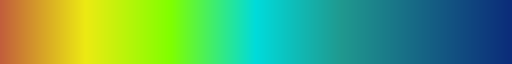

In [25]:
# Convert the colour palette dataframe to a Matplotlib Linear Segmented colourmap
mycmp=ctable_to_LScolormap(ctable,skipFirstLine=False)
mycmp

In [26]:
# Load the netCDF file with the masked ST July 2021 data
ds = xr.open_dataset("HRVPP_SEASONAL_TRAJECTORIES_JULY2021.nc")
ds

<xarray.Dataset>
Dimensions:  (t: 3, x: 4380, y: 1748)
Coordinates:
  * t        (t) datetime64[ns] 2021-07-01 2021-07-11 2021-07-21
  * x        (x) float64 6.357 6.358 6.358 6.358 ... 6.961 6.961 6.961 6.962
  * y        (y) float64 49.61 49.61 49.61 49.61 ... 49.37 49.37 49.37 49.37
Data variables:
    crs      |S1 ...
    PPI      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.30.2a1
    description:  
    title:

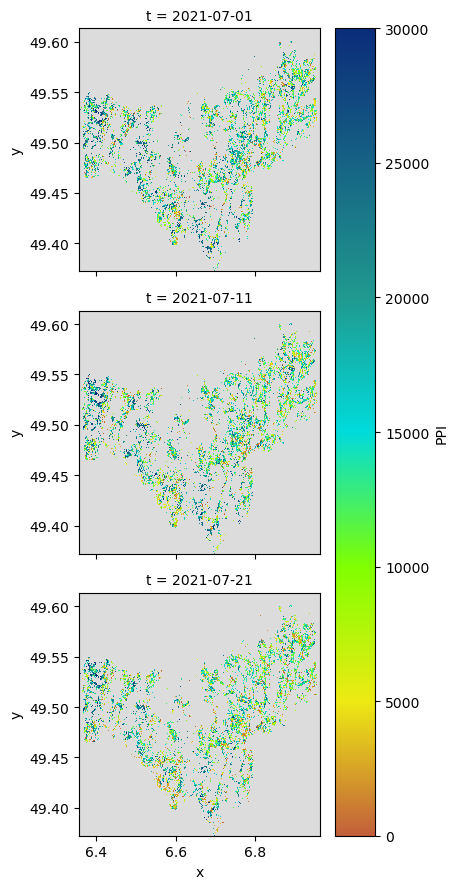

In [27]:
# Plot the data
ds.PPI.plot(vmin=0, vmax=30000.0, cmap=mycmp, col="t", col_wrap=1)

### Let's repeat the data loading and masking for a larger time period

In [37]:
# load in the data cube for desired area and March till Oct 2021 period and mask it on land cover
cube_st_ppi = connection.load_collection("COPERNICUS_PLANT_PHENOLOGY_INDEX",
                                        temporal_extent= ["2021-03-01","2021-10-01"],
                                        bands=["PPI"]).filter_spatial(dec02_area)

mask_for_ppi = classmask.max_time().resample_cube_spatial(cube_st_ppi)
masked_cube_st_ppi = cube_st_ppi.mask(mask_for_ppi)

#excecute the job and 
job = masked_cube_st_ppi.execute_batch(outputfile = 'HRVPP_SEASONAL_TRAJECTORIES.nc',
                                description='benchmarking-creo',
                                job_options={'driver-memory': '1g'},
                                sample_by_feature = True,
                                validate = False)

0:00:00 Job 'j-240503267cca431cab9a985d615e70b1': send 'start'
0:00:13 Job 'j-240503267cca431cab9a985d615e70b1': created (progress N/A)
0:00:18 Job 'j-240503267cca431cab9a985d615e70b1': created (progress N/A)
0:00:25 Job 'j-240503267cca431cab9a985d615e70b1': created (progress N/A)
0:00:33 Job 'j-240503267cca431cab9a985d615e70b1': created (progress N/A)
0:00:43 Job 'j-240503267cca431cab9a985d615e70b1': created (progress N/A)
0:00:55 Job 'j-240503267cca431cab9a985d615e70b1': created (progress N/A)
0:01:11 Job 'j-240503267cca431cab9a985d615e70b1': running (progress N/A)
0:01:30 Job 'j-240503267cca431cab9a985d615e70b1': running (progress N/A)
0:01:54 Job 'j-240503267cca431cab9a985d615e70b1': running (progress N/A)
0:02:24 Job 'j-240503267cca431cab9a985d615e70b1': running (progress N/A)
0:03:01 Job 'j-240503267cca431cab9a985d615e70b1': running (progress N/A)
0:03:48 Job 'j-240503267cca431cab9a985d615e70b1': running (progress N/A)
0:04:47 Job 'j-240503267cca431cab9a985d615e70b1': running (pr

### Retrieve time series statistics over the NUTS polygon and visualize the vegetation growth cycle

Aggregate the loaded data cube (masked HR-VPP Seasonal Trajectories PPI values)
spatially over the desired NUTS area to compute area statistics over time.

Statistics are saved in a Comma-Separated Value (CSV) file.

For reference:
*https://open-eo.github.io/openeo-python-client/basics.html#computing-multiple-statistics*

In [38]:
season_aggregation = masked_cube_st_ppi.aggregate_spatial(
    geometries=dec02_area,
    reducer=lambda x: array_create([mean(x), sd(x), quantiles(x,q=4)]))

job = season_aggregation.execute_batch(outputfile = 'hrvpp_st_ts.csv',
                                description='benchmarking-creo',
                                job_options={'driver-memory': '1g'},
                                sample_by_feature = True,
                                validate = False)

0:00:00 Job 'j-240503dc86bf46e0a05b0473d911a352': send 'start'
0:00:14 Job 'j-240503dc86bf46e0a05b0473d911a352': created (progress N/A)
0:00:19 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:00:25 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:00:33 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:00:43 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:00:56 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:01:11 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:01:31 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:01:55 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:02:25 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:03:02 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:03:49 Job 'j-240503dc86bf46e0a05b0473d911a352': running (progress N/A)
0:04:48 Job 'j-240503dc86bf46e0a05b0473d911a352': running (pr

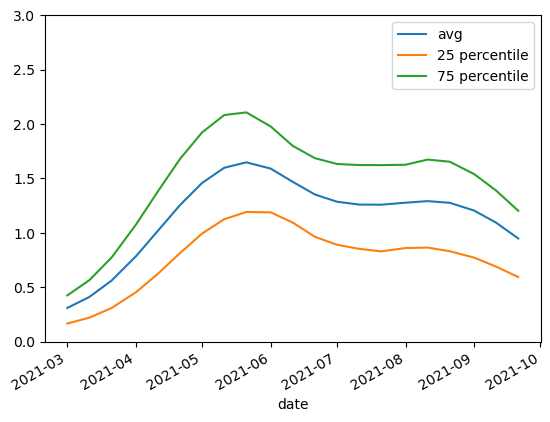

In [39]:
# Read-back the CSV file
df = pd.read_csv("hrvpp_st_ts.csv",index_col=["date","feature_index"],parse_dates=['date']).sort_index()

# And plot the statistics
df_xs=(df.xs(0, level='feature_index', drop_level=True)/10000.0) \
        .drop(['percentile_approx(band_0, 0.5, 100000)','stddev_samp(band_0)'],axis=1) \
        .rename(columns={'avg(band_0)':'avg', 'percentile_approx(band_0, 0.25, 100000)':'25 percentile', 'percentile_approx(band_0, 0.75, 100000)':'75 percentile'}) \
        .plot(ylim=[0,3])